<a href="https://colab.research.google.com/github/shanizu/FLUORA/blob/main/FLUORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


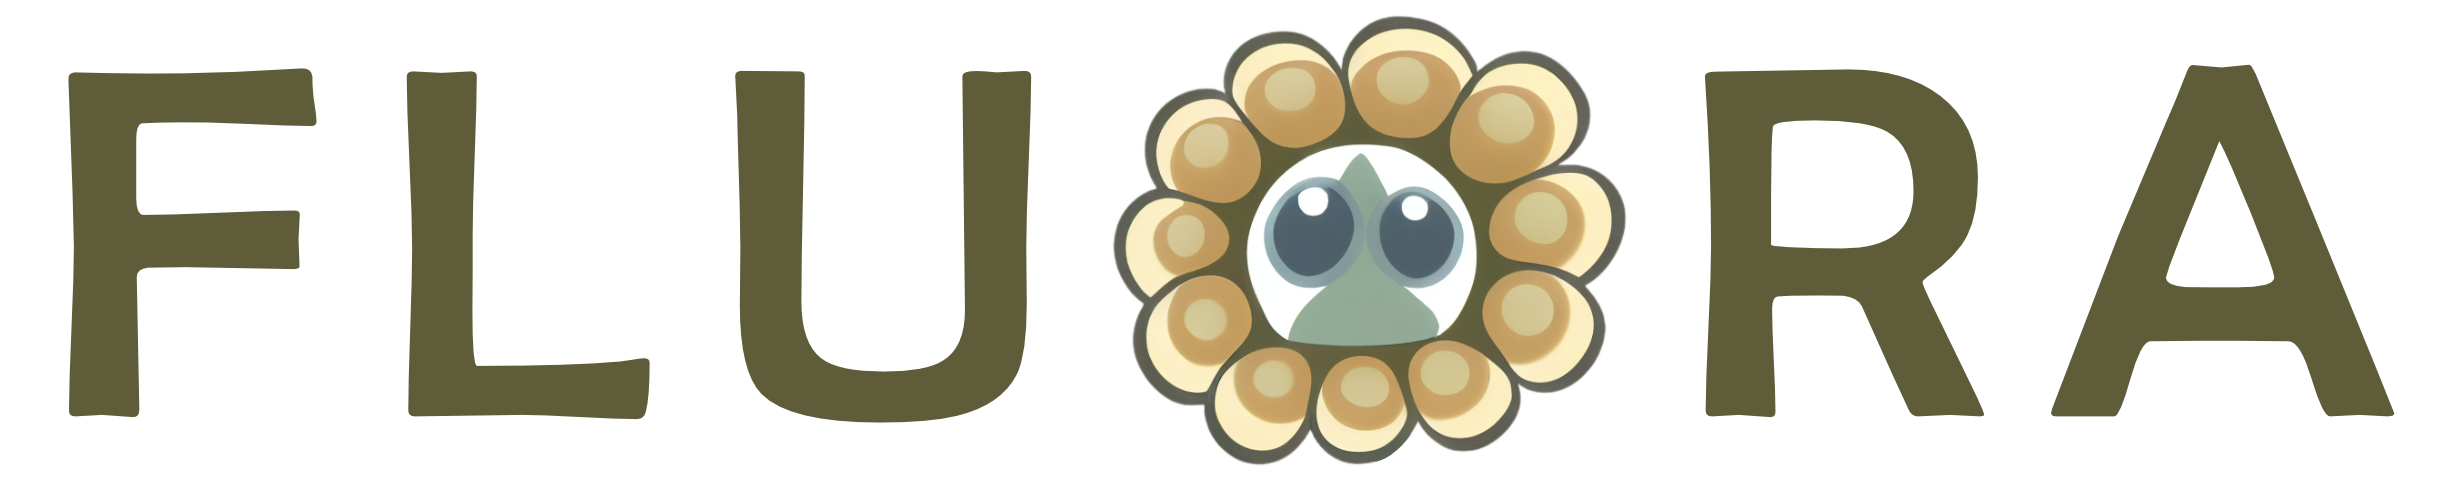
#**Cloud-based Fluorescent Cell Labeling and Analysis with Google Colab**
This Google Colab notebook provides an easy-to-use and accessible interface for the FLUORA software, a powerful tool designed for labeling and analyzing fluorescent cells in time-series microscopy images. With seamless integration of Cellpose-generated segmentation masks, this notebook enables both novice and advanced users to effectively process and analyze their data in a cloud-based environment.

## SET UP
#### *Required for both segmentation and/or labeling*.

In [1]:
#@title 1. Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
#Supress default INFO logging
%%capture

!pip install cellpose
!pip install plotly --upgrade
!pip install opencv-python-headless==4.1.2.30

#@title 2. Imports and functions{ display-mode: "form" }

#@markdown Check if you are using Cellpose. If you are using Cellpose for your analysis, it is highly recommended to change runtype to "GPU". CPU-based segmentation will be 10x slower.
CELLPOSE = True #@param {type:"boolean"}

#System
import os, shutil, sys, math, random
import os.path
import glob
import gc
from pathlib import Path
from tqdm.notebook import tqdm
%load_ext google.colab.data_table
import io as io_
from collections import deque
from typing import Dict, List, Union

#Data structure
import pandas as pd
import numpy as np

#Image Processing
if CELLPOSE == True:
  from cellpose import models, utils
from skimage import io, measure
from ipywidgets import *
import ipywidgets as widgets
from scipy.spatial.distance import cdist
from PIL import Image, ImageOps

#Visualization
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from matplotlib.colors import ListedColormap

#Learning
from sklearn.model_selection import train_test_split
from tensorflow import get_logger, keras
from tensorflow.keras.callbacks import EarlyStopping
get_logger().setLevel('ERROR')

#Cellpose2.0
!pip install "opencv-python-headless<4.3"
!pip install cellpose
!nvcc --version
!nvidia-smi
from cellpose import core, utils, io, models

#omnipose includes cellpose
!pip install omnipose==0.4.4
from cellpose_omni import models, core, utils, io

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

#Functions
def seg_what(image, channelToSegment, frameToSegment):
  """
  Extracts a single channel and/or frame from a multi-dimensional image.

  Parameters:
    image (numpy.ndarray): The image to extract from.
    channelToSegment (int): The index of the channel to extract.
      If the image is 2D, this parameter is ignored.
    frameToSegment (int or str): The index of the frame to extract, or 'all' to extract all frames.

  Returns:
    numpy.ndarray: The extracted channel and/or frame.
  """
  # If the image has 3 dimensions, keep all dimensions. Otherwise, extract the specified channel.
  if image.ndim == 3:
    image = image
  else:
    image = image[channelToSegment]

  # If a specific frame is specified, extract it. Otherwise, keep all frames.
  if frameToSegment != 'all':
    image = image[frameToSegment]

  return image

def show_overlay(tif_to_analyze_color_layer, masks, parameters):
  """
  Displays an image with outlines overlaid in white and ROI numbers added to the plot.

  Parameters:
    tif_to_analyze_color_layer (numpy.ndarray): The image to display.
    masks (numpy.ndarray): A binary mask of the regions of interest.
    parameters (str): Additional parameters to display on the plot.

  Returns:
    None
  """
  # Plot image with outlines overlaid in white
  outlines = utils.outlines_list(masks) # Gets outlines of masks as a list
  fig = plt.figure(figsize=(15,15)) # Creates a new figure
  plt.imshow(tif_to_analyze_color_layer) # Displays data as an image on the figure

  # Add ROI numbers to plot
  for i,o in enumerate(outlines): # Loops thru each ROI outline
    y,x = np.nonzero(masks == (i+1)) # Return the indices of the elements that are non-zero
    ymed = np.median(y) # Get median y coordinate
    xmed = np.median(x) # Get median x coordinate
    plt.text(xmed, ymed, '%d'%(i), color='white') # Write ROI outline number at median (x,y)
    plt.plot(o[:,0], o[:,1], color='w') # [:,0] means [first_row:last_row, column_0]

  plt.text(x=8, y=20, s=parameters, color='white', fontsize=12)
  plt.axis('off')
  plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

  io_buf = io_.BytesIO()
  fig.savefig(io_buf, format='raw')
  io_buf.seek(0)
  img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                     newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
  io_buf.close()


# FLUORA Cell Identification Functions and Classes

## Cell Similarity Metrics
def calculate_iou(cell1: int, frame1: np.ndarray, cell2: int, frame2: np.ndarray):
  """
  Calculates the Intersection over Union (IoU) of two cells in two frames.

  Args:
    cell1: The ID of the first cell to compare.
    frame1: A numpy ndarray representing the first frame.
    cell2: The ID of the second cell to compare.
    frame2: A numpy ndarray representing the second frame.

  Returns:
    The IoU of the two cells, as a float between 0 and 1.

  Raises:
    ValueError: If either cell ID is zero (which represents the background).
  """
  if cell1 != 0 and cell2 != 0:
    mask1 = frame1 == cell1
    mask2 = frame2 == cell2
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union
  else:
    raise ValueError("Both cells must have non-zero IDs")
  return iou

def cosine_similarity(vec1, vec2):
  """
  Computes the cosine similarity between two vectors.

  Args:
    vec1: np.array, the first vector
    vec2: np.array, the second vector
  Returns:
    float, the cosine similarity between vec1 and vec2
  """
  dot_product = np.dot(np.squeeze(vec1), np.squeeze(vec2))
  vec1_norm = np.linalg.norm(vec1)
  vec2_norm = np.linalg.norm(vec2)
  similarity = dot_product / (vec1_norm * vec2_norm)
  return similarity

## Image Processing
def read_multiframe_tif(filename: str,
                        channel_selection: List[int]=[1]) -> list[np.ndarray]:
  """
  Reads a multi-frame tif file and returns a list of ndarrays of frames
  for the selected channels.

  Args:
    filename: The name of the tif file to read.
    channel_selection: A list of binary values (0 or 1), where the length
      is equal to the number of channels, and each value indicates whether
      the corresponding channel should be extracted (1) or not (0).
      (Default  [1], no channels)

  Returns:
    A list of numpy ndarrays containing the frames for the selected channels.
    The frames are in order of channel selected, then frame number.
  """
  img = Image.open(filename)
  n_frames_total = img.n_frames
  n_channels = len(channel_selection)

  selected_frames = []

  for channel, is_selected in enumerate(channel_selection):
    if is_selected:
      channel_frames = []
      for i in range(channel, n_frames_total, n_channels):
        img.seek(i)
        channel_frames.append(np.array(img))
      selected_frames.extend(np.array(channel_frames))
  return selected_frames

def process_image(img_data, size=(28, 28)) -> np.ndarray:
  """
  Rescale, convert to grayscale, pad, and normalize an input image.

  Args:
    img_data (numpy.array): Input image as a numpy array.
    size (tuple, optional): Desired output size (width, height). Default: (28, 28).

  Returns:
    np.ndarray of processed and rescaled image with pixel values in range [0, 1].
  """
  # Check if the image is too small
  if img_data.shape[0] < size[0] or img_data.shape[1] < size[1]:
    return None

  # Normalize the image to the range [0, 1]
  min_val, max_val = np.min(img_data), np.max(img_data)
  normalized_image = (img_data - min_val) / (max_val - min_val)

  # Convert image to PIL Image format, to grayscale, and pad to the desired size
  img = Image.fromarray((normalized_image * 255).astype(np.uint8))
  img = img.convert('L')
  img = ImageOps.pad(img, size, method=Image.NEAREST)

  # Convert the image back to a numpy array
  img_array = np.array(img) / 255

  del min_val, max_val, normalized_image, img
  return img_array

def extract_cells(images_path: str, masks_path: str,
                channel_selection: list[int]=[1]) -> Dict[str, np.ndarray]:
  """
  Extracts individual cell images from a multi-frame image and mask file, and writes
  them to a dictionary.

  Args:
    images_path (str): The path to the multi-frame image file.
    masks_path (str): The path to the multi-frame mask file.
    channel_selection: A list or tuple of binary values (0 or 1), where
      the length is equal to the number of channels, and each value
      indicates whether the corresponding channel should be extracted (1)
      or not (0). (Default  [1], no channels)

  Returns:
    dict: A dictionary containing processed cell images with keys in the format
    "frame_{frame_idx}_cell_{cell_id}".
  """
  image_frames = read_multiframe_tif(images_path, channel_selection)
  mask_frames = read_multiframe_tif(masks_path)

  cell_dict = {}
  for frame_idx, (image_frame, mask_frame) in enumerate(
    tqdm(zip(image_frames, mask_frames),
          total=len(image_frames),
          desc='Extracting cells',
          unit="frame")):
    cell_ids = set(mask_frame.flatten())
    if 0 in cell_ids:
      cell_ids.remove(0)

    for cell_id in cell_ids:
      cell_coords = (mask_frame == cell_id).nonzero()
      x_min, x_max = min(cell_coords[0]), max(cell_coords[0])
      y_min, y_max = min(cell_coords[1]), max(cell_coords[1])

      cell_mask = (mask_frame == cell_id)
      clipped_image = image_frame * cell_mask
      cell_image = clipped_image[x_min:x_max+1, y_min:y_max+1]
      processed_img = process_image(cell_image)

      if processed_img:
        cell_dict[f"frame_{frame_idx}_cell_{cell_id}"] = processed_img
  del image_frames, mask_frames
  return cell_dict

def get_deltaF(df: pd.DataFrame, channel: str) -> pd.DataFrame:
    '''
    Calculates the deltaF/F for each cell in a dataframe.

    Args:
        df (pd.DataFrame): A dataframe containing the cell images and metadata.
        channel (str): The channel to use for calculating deltaF/F.

    Returns:
        pd.DataFrame: A dataframe containing the cell images, metadata, and deltaF/F.
    '''
    df = df[df['Channel'] == channel]
    df = df.dropna()

    delta = pd.DataFrame()
    for ID in df['Label'].unique():
        temp_df = df[df['Label'] == ID]
        base_F = temp_df.head(5)['Intensity'].mean()
        temp_df['deltaoverFo'] = temp_df['Intensity'] / base_F
        delta = delta.append(temp_df)
    return delta

## Cell Lineage Management
class Cell:
  def __init__(self, cell_id: int, lineage_id: int, frame: int, x: float, y: float):
    """
    Initializes a new Cell object.

    Args:
      cell_id: The unique ID of the cell.
      lineage_id: The ID of the cell's lineage.
      frame: The frame index in which the cell first appears.
      x: The x-coordinate of the cell's centroid.
      y: The y-coordinate of the cell's centroid.

    Returns:
      None
    """
    self.cell_id = cell_id
    self.lineage_id = lineage_id
    self.frame = frame
    self.x = x
    self.y = y

  def __repr__(self):
    return (
      f'Cell {self.cell_id} from Lineage {self.lineage_id}',
      f'at Frame {self.frame} with centroid ({self.x}, {self.y})'
      )

class Library:
  def __init__(self, init_mask: np.ndarray, df: pd.DataFrame):
    """
    Initializes a new Library object and populates it with Cell objects based on an
    initial mask and DataFrame.

    Args:
      init_mask: A numpy ndarray representing the initial cell mask.
      df: A pandas DataFrame containing cell information.

    Returns:
      None
    """
    self.lineages = []
    for cell in np.unique(init_mask):
      if cell != 0:
        cell_info = df[(df['Frame']==0) & (df['ROI']==(cell-1))]
        x = cell_info['x'].iloc[0]
        y = cell_info['y'].iloc[0]
        new_cell = Cell(cell, cell, 0, x, y)
        self.add_cell(new_cell)
    del cell, cell_info, x, y, new_cell

  def add_cell(self, cell: Cell) -> None:
    """
    Adds a Cell object to the Library object.

    Args:
      cell: A Cell object to be added to the Library.

    Returns:
      None[]
    """
    if cell.lineage_id > len(self.lineages):
      self.lineages.extend(
        deque() for _ in range(cell.lineage_id - len(self.lineages)))
    self.lineages[cell.lineage_id-1].append(cell)

  def to_dataframe(self) -> pd.DataFrame:
    """
    Converts the Library object to a pandas DataFrame.

    Returns:
      A pandas DataFrame containing information about each Cell object
      in the Library.
    """
    data = []
    for i, lineage in enumerate(self.lineages):
      for cell in lineage:
        data.append({
          'cell_id': cell.cell_id,
          'lineage_id': i+1,
          'Frame': cell.frame,
          'x': cell.x,
          'y': cell.y
          })
    return pd.DataFrame(data)

  def all_recent(self) -> List[Dict[str, Union[int, float]]]:
    """
    Returns a list of dictionaries representing the most recent Cell object
    in each lineage.

    Returns:
      A list of dictionaries, where each dictionary represents the most recent
      Cell object in a lineage. Each dictionary has the following keys:
      'cell_id', 'lineage_id', 'frame', 'x', 'y', with corresponding values for
      each attribute of the Cell object.
    """
    recent_cells = []
    for i, lineage in enumerate(self.lineages):
      if len(lineage) > 0:
        cell = lineage[-1]
        recent_cells.append({
          'cell_id': cell.cell_id,
          'lineage_id': i + 1,
          'frame': cell.frame,
          'x': cell.x,
          'y': cell.y
          })
    return recent_cells

  def is_recent_cell(self, frame: int, cell_id: int) -> int:
    """
    Checks if a cell is a recent cell based on the frame number and cell id.

    Args:
      frame: The frame number to check.
      cell_id: The cell id to check.

    Returns:
      The lineage number the cell was found in if it is a recent cell; else, -1.
    """
    for lineage_id, lineage in enumerate(self.lineages, start=1):
      if len(lineage) > 0:
        recent_cell = lineage[-1]
        if recent_cell.frame == frame and recent_cell.cell_id == cell_id:
          return lineage_id
    return -1

  def calculate_scores(self,
                      current_frame: int,
                      recent_cell: Dict,
                      prev_mask: np.ndarray,
                      new_cells: List[int],
                      mask: np.ndarray,
                      info_df: pd.DataFrame,
                      cell_vectors: Dict[str, np.ndarray]
                      ) -> List[Dict]:
    """
    Calculates the similarity scores between a recent cell and a list of new cells.

    Args:
      current_frame: The frame number of the current frame.
      recent_cell: A dictionary representing the most recent cell in a lineage.
      prev_mask: A numpy ndarray representing the previous cell mask.
      new_cells: A list of cell ids representing the new cells in current frame.
      mask: A numpy ndarray representing the current cell mask.
      info_df: A pandas DataFrame containing cell information.
      cell_vectors: A dictionary containing cell vectors.

    Returns:
      A list of dictionaries, where each dictionary represents a new cell in the
      current frame. Each dict has the following keys: 'cell_id', 'lineage_id',
      'frame', 'x', 'y', 'iou_score', 'visual_score', 'distance', 'total_score',
      with corresponding values for each attribute of the Cell object.
    """
    key = f'frame_{recent_cell["frame"]}_cell_{recent_cell["cell_id"]}'
    recent_vec = cell_vectors[key]

    scores = []
    for new_cell in new_cells:
      if self.is_recent_cell(current_frame, new_cell) == -1:
        x_new, y_new = (
          info_df[info_df['ROI'] == (new_cell - 1)].iloc[0][['x', 'y']]
          )

        iou_score = calculate_iou(recent_cell['cell_id'], prev_mask,
                                  new_cell, mask)

        if iou_score > 0:
          key = f'frame_{current_frame}_cell_{new_cell}'
          new_vec = cell_vectors[key]
          visual_score = cosine_similarity(recent_vec, new_vec)

          distance = math.sqrt(
            (x_new - recent_cell['x'])**2 +
            (y_new - recent_cell['y'])**2
            )

          scores.append({
            'next_cell_id': new_cell,
            'next_cell_x': x_new,
            'next_cell_y': y_new,
            'lineage_id': recent_cell['lineage_id'],
            'iou_score': iou_score,
            'visual_score': visual_score,
            'distance': distance
            })
    return scores

  def identify_cells(self, current_frame: int, scores: List[Dict],
                  iou_weights=0.6, visual_weights=0.4) -> None:
    """
    Find the best matching cell based on IoU and visual scores, and add it to the
    Lineage Library.

    Args:
      current_frame (int): Frame number of potential matching cells.
      cell (dict): Reference cell with its features.
      scores (list of dict): Potential matching cells with their
        features and scores.

    Returns:
      None
    """
    if not scores:
      return

    visual_scores = np.array([score['visual_score'] for score in scores])
    min_vis_score = np.min(visual_scores)
    max_vis_score = np.max(visual_scores)
    vis_score_range = max_vis_score - min_vis_score

    if vis_score_range != 0:
      visual_scores = (visual_scores - min_vis_score) / vis_score_range
    else:
      visual_scores = np.ones_like(visual_scores)

    normalized_scores = (
      iou_weights * np.array([score['iou_score'] for score in scores]) +
      visual_weights * visual_scores
    )

    while scores:
      match_index = np.argmax(normalized_scores)

      matched_cell = Cell(
        cell_id = scores[match_index]['next_cell_id'],
        lineage_id = scores[match_index]['lineage_id'],
        frame = current_frame,
        x = scores[match_index]['next_cell_x'],
        y = scores[match_index]['next_cell_y']
        )
      self.add_cell(matched_cell)

      matched_cell_id = scores[match_index]['next_cell_id']

      cell_id_indices = [i for i, score in enumerate(scores)
                          if score['next_cell_id'] == matched_cell_id]
      scores = [score for score in scores
                if score['next_cell_id'] != matched_cell_id]
      normalized_scores = np.delete(normalized_scores, cell_id_indices)

  def remove_short_lineages(self, min_percent: float, total_frames: int) -> None:
    """
    Remove lineages that have been tracked for fewer frames than
    min_percent/100*total_frames.

    Parameters:
      min_percent: float
        Minimum percentage of total frames that a lineage must
        be tracked for in order to be kept.
      total_frames: int
        Total number of frames in the video.

    Returns:
      None
    """
    min_frames = min_percent / 100 * total_frames
    self.lineages = [
      lineage for lineage in self.lineages if len(lineage) >= min_frames
      ]

## Frame-by-frame Pairwise Labeling
def frame_by_frame(lib: Library, masks: List[np.ndarray], df: pd.DataFrame,
                   cell_vectors: dict, search_radius: float, connectivity: int
                   ) -> Library:
  """
  Process each frame of the image sequence and identify cells that are similar to
  previously identified cells in the lineage library.

  Args:
    lib: A lineage library object.
    masks: List of numpy arrays with binary masks for each frame.
    df: A pandas DataFrame containing information about each cell in each frame.
    cell_vectors: Dictionary with feature vectors for each cell.
    search_radius: Float value for max distance between similar cells.
    connectivity: Integer value for minimum frames per lineage.
  Returns:
    A lineage library object containing identified cells and their lineages.
  """
  for i, mask in tqdm(enumerate(masks[1:]), total=len(masks)-1,
                      desc="Processing Frames", unit="frame"):
    current_frame = i + 1
    temp_df = df[df['Frame'] == current_frame]

    scores = []
    for recent_cell in lib.all_recent():
      curr_mask = masks[current_frame]
      prev_mask = masks[recent_cell['frame']]

      key = f'frame_{recent_cell["frame"]}_cell_{recent_cell["cell_id"]}'
      if key not in cell_vectors:
        continue
      recent_vec = cell_vectors[key]

      new_cells = np.unique(curr_mask)[1:]
      new_cells = new_cells[new_cells != 0]

      recent_cell_coords = np.array([recent_cell['x'], recent_cell['y']])
      new_cell_coords = (
        temp_df[temp_df['ROI'].isin(new_cells - 1)][['x', 'y']].to_numpy()
        )
      distances = cdist(recent_cell_coords.reshape(1, -1), new_cell_coords)[0]
      new_cells = new_cells[distances < search_radius]

      for new_cell in new_cells:
        if lib.is_recent_cell(current_frame, new_cell) == -1:
          x_new, y_new = (
            temp_df[temp_df['ROI'] == (new_cell - 1)].iloc[0][['x', 'y']]
            )

          iou_score = calculate_iou(recent_cell['cell_id'], prev_mask,
                                    new_cell, mask)

          if iou_score > 0:
            key = f'frame_{current_frame}_cell_{new_cell}'
            if key not in cell_vectors:
              continue
            new_vec = cell_vectors[key]
            visual_score = cosine_similarity(recent_vec, new_vec)

            distance = math.sqrt(
              (x_new - recent_cell['x'])**2 +
              (y_new - recent_cell['y'])**2
              )

            scores.append({
              'next_cell_id': new_cell,
              'next_cell_x': x_new,
              'next_cell_y': y_new,
              'lineage_id': recent_cell['lineage_id'],
              'iou_score': iou_score,
              'visual_score': visual_score,
              'distance': distance
              })
    lib.identify_cells(current_frame, scores)
  lib.remove_short_lineages(connectivity, len(masks))
  return lib

In [13]:
#@title 3. Experiment information{ display-mode: "form" }
#Experiment information entry
date = "2023-07-17" #@param {type:"date"}
expID = "pH_acidocis_menadione_bg" #@param {type: "string"}
path = "/content/drive/Shareddrives/H2O2/data/dropbox/1_Experiment/20230530_pH_acidocis_menadione/bg100" #@param {type:"string"}
parseID = "Well_Trial" #@param {type:"string"}
seperator = "_" #@param {type:"string"}
MultiChannel = True #@param {type:"boolean"}
channelInfo = "GFP_NIR" #@param {type:"string"}
channelToSegment = "GFP" #@param {type:"string"}
frameToSegment =  'all' #@param {type:"string"}
Expnote = "" #@param {type:"string"}

#Experiment information entry preprocessing
parent_folder = path[:path.rfind(os.path.sep)]
parseID = parseID.split(sep=seperator)
channelInfo = channelInfo.split(sep=seperator)
if frameToSegment != 'all':
  frameToSegment = int(frameToSegment)

#Create new directory, save information about the experiment
isDirectory = os.path.isdir(path)
if os.path.splitext(path)[-1].lower() == '.tif':
  folder = os.path.abspath(os.path.join(path, os.pardir))
elif isDirectory == True:
  folder = path

#Create a folder where segmentation is saved
Path(folder + "/" + date + "_" + expID).mkdir(parents=True, exist_ok=True)
Path(folder + "/" + date + "_" + expID + "/segmentations").mkdir(parents=True, exist_ok=True)

#Experiment Info saved to text file (if doesn't exist)
if os.path.exists(folder + "/" + date + "_" + expID + '/info_exp.txt'):
  pass
else:
  f = open(folder + "/" + date + "_" + expID + '/info_exp.txt', 'w')
  f.write("date: " + repr(date) + '\n')
  f.write("expID: " + repr(expID) + '\n')
  f.write("path: " + repr(path) + '\n')
  f.write("parseID: " + repr(parseID) + '\n')
  f.write("seperator: " + repr(seperator) + '\n')
  f.write("MultiChannel: " + repr(MultiChannel) + '\n')
  f.write("channelInfo: " + repr(channelInfo) + '\n')
  f.write("Expnote: " + repr(Expnote) + '\n')
  f.close()


#Run Segmentation

In [5]:
#@title 1. Segmentation information{ display-mode: "form" }
Cellpose = True #@param {type:"boolean"}
Omnipose = False #@param {type:"boolean"}
Custom_Model = False #@param {type:"boolean"}
#@markdown -  if the Custom_Model is selected, provide model_path
model_path = "" #@param {type:"string"}

if Omnipose == True:
  onot = 1
else:
  onot = 0

https://www.cellpose.org/models/cyto2torch_0 /root/.cellpose/models/cyto2torch_0


100%|██████████| 25.3M/25.3M [00:00<00:00, 57.1MB/s]


https://www.cellpose.org/models/cyto2torch_1 /root/.cellpose/models/cyto2torch_1


100%|██████████| 25.3M/25.3M [00:00<00:00, 55.6MB/s]


https://www.cellpose.org/models/cyto2torch_2 /root/.cellpose/models/cyto2torch_2


100%|██████████| 25.3M/25.3M [00:00<00:00, 58.9MB/s]


https://www.cellpose.org/models/cyto2torch_3 /root/.cellpose/models/cyto2torch_3


100%|██████████| 25.3M/25.3M [00:00<00:00, 67.2MB/s]


https://www.cellpose.org/models/size_cyto2torch_0.npy /root/.cellpose/models/size_cyto2torch_0.npy


100%|██████████| 3.54k/3.54k [00:00<00:00, 1.63MB/s]


/content/drive/Shareddrives/H2O2/data/dropbox/1_Experiment/20230530_pH_acidocis_menadione/bg100/Well8_WT.tif


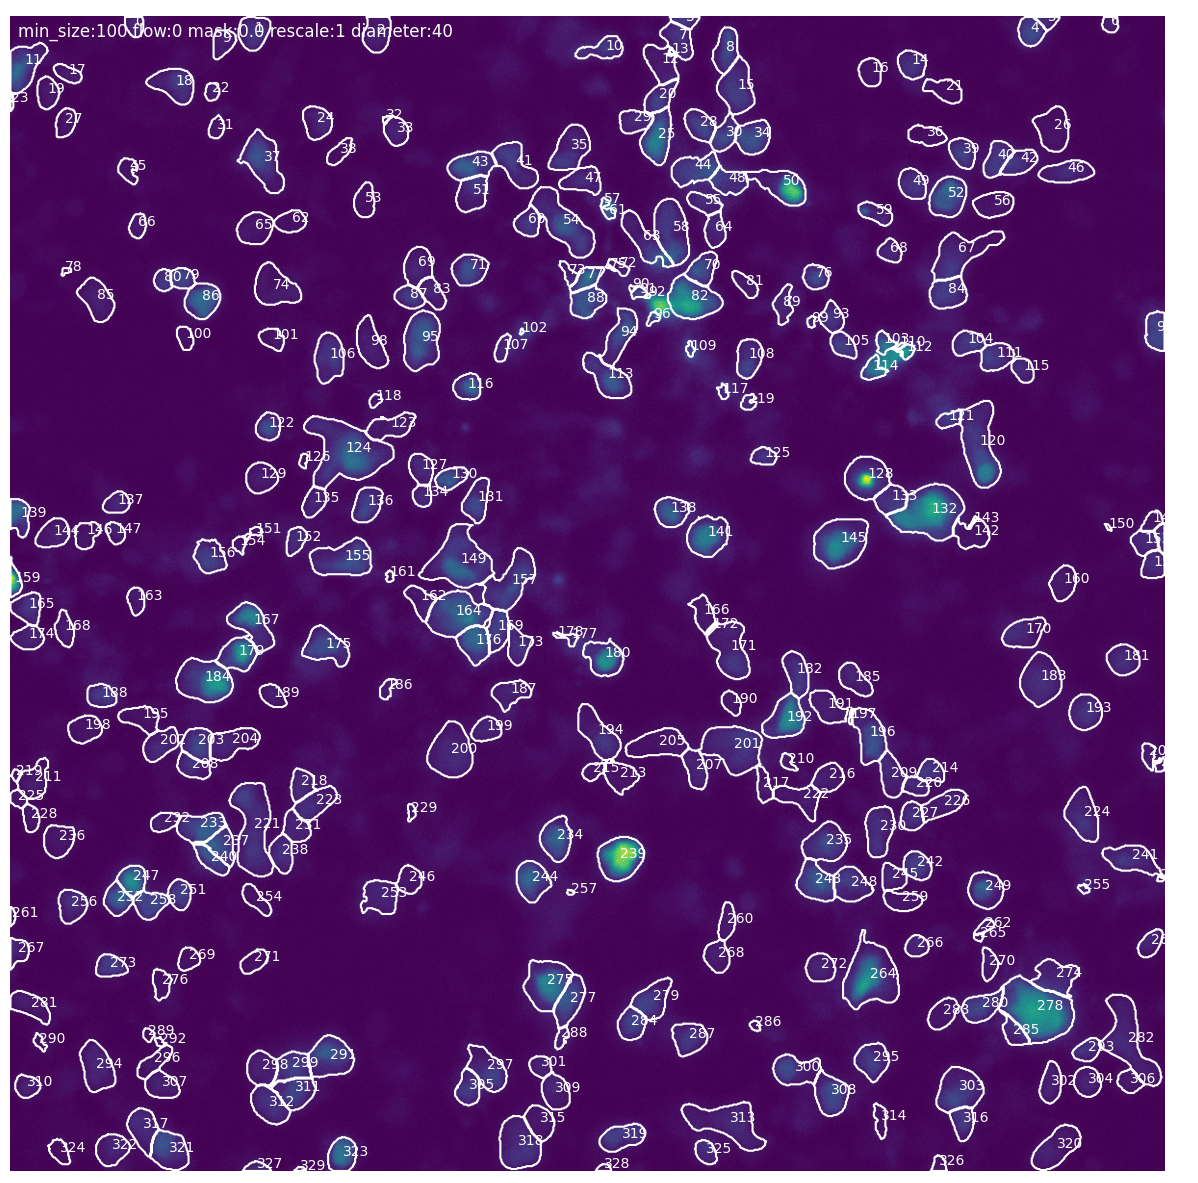

In [6]:
#@title 2. Check segmentation
min_size = 100 #@param
flow_threshold= 0 #@param
mask_threshold= 0.0 #@param
rescale =   1 #@param {type:"raw"}
diameter =  40#@param {type:"raw"}
if not diameter:
  diameter = 30

# declare model
if Custom_Model == True:
  model = models.CellposeModel(gpu='use_GPU', pretrained_model=model_path)
elif Omnipose == True:
  model = models.CellposeModel(gpu='use_GPU', model_type='cyto2_omni')
model = models.Cellpose(gpu='use_GPU', model_type='cyto2')

#Find image files
if isDirectory == True:
  files = sorted(glob.glob(path + '/' + '*.tif'))
elif os.path.splitext(path)[-1].lower() == '.tif':
  files = [path]

chosen = random.choices(files, k=1)

image = io.imread(chosen[0])

#Handle dimensions, should be 4 dim (frames, channels, height, width)
if image.ndim == 2:
    image = image[np.newaxis, np.newaxis, :, :]
elif image.ndim == 3:
    image = image[np.newaxis, :, :, :]
elif image.ndim == 4 and image.shape[0] > 1 and image.shape[1] > 1:
    # If the image has 4 dimensions and the dimensions are ordered as (channels, frames, height, width),
    # rearrange the array into shape (frames, channels, height, width)
    image = np.transpose(image, (1, 0, 2, 3))

#Create example image
rep_image = image[0] # select first frame
if MultiChannel: # select proper to channel to segment
  rep_image = rep_image[channelInfo.index(channelToSegment)] # select proper to channel to segment
rep_image = np.squeeze(rep_image) #ensure there are no extra dimensions

masks, flows, styles, diams = model.eval(rep_image, channels=[0,0], flow_threshold=flow_threshold,
                                         min_size=min_size, omni=onot, diameter=diameter)

info = 'min_size:' + str(min_size)+ ' flow:' + str(flow_threshold) +' mask:' + str(mask_threshold) + ' rescale:' + str(rescale) + ' diameter:' + str(diams)

print(chosen[0])
show_overlay(rep_image, masks, info)
del image, rep_image, masks, flows, styles, diams

In [7]:
#@title 3. Run segmentation and save

cTS = channelInfo.index(channelToSegment)
master_df = pd.DataFrame()

if isDirectory == True:
  files = sorted(glob.glob(path + '/' + '*.tif'))

elif os.path.splitext(path)[-1].lower() == '.tif':
  files = [path]
  single_file = True

for path in tqdm(files, desc='files completed'):
  lst_parsed = path[path.rfind(os.path.sep)+1:-4].split(sep=seperator)
  parsedID = {}
  for i, ID in enumerate(parseID):
    parsedID[ID] = lst_parsed[i]

  image = io.imread(path)
  if image.ndim == 2:
    image = image[np.newaxis, np.newaxis, :, :]
  elif image.ndim == 3:
    image = image[np.newaxis, :, :, :]

  img_shape = image.shape
  if (img_shape[image.ndim-2] != img_shape[image.ndim-1]):
    Dme = 0, 3, 1, 2
    image = np.transpose(image, Dme)
  if (img_shape[0] > 5) and (img_shape[0] > img_shape[1]):
    Dme = 1, 0, 2, 3
    image = np.transpose(image, Dme)

  img_to_seg = seg_what(image, cTS, frameToSegment)
  if frameToSegment == 'all':
    img_lst = [i for i in img_to_seg]
  else:
    img_lst = [img_to_seg]

  masks, flows, styles, diams = model.eval(img_lst, channels=[0,0], flow_threshold=flow_threshold,
                                           min_size=min_size, omni=onot, diameter=diameter)


  name, ftype = os.path.basename(path).split(".")
  if len(masks) == 1:
    io.imsave(folder + "/" + date + "_" + expID + "/segmentations/" + name + "_seg." + ftype,
              masks[0])
  else:
    masks_stack = np.stack(masks)
    io.imsave(folder + "/" + date + "_" + expID + "/segmentations/" + name + "_seg." + ftype,
              masks_stack)
    del masks_stack


  file_properties=[]
  for i, channel in enumerate(image):
    channel_prop=[]
    for j, frame in enumerate(channel):
      if len(masks) == 1:
        channel_prop.append(measure.regionprops(masks[0], frame))
      else:
        channel_prop.append(measure.regionprops(masks[j], frame))
    file_properties.append(channel_prop)
  del img_to_seg, img_lst, flows, styles, diams, masks

  row_list = []
  for i, channel_properties in enumerate(file_properties):
    for j, frame_properties in enumerate(channel_properties):
      for k, roi_properties in enumerate(frame_properties):
        add_dict = {}
        add_dict['Intensity'] = roi_properties.mean_intensity
        add_dict['Centroid'] = roi_properties.centroid
        add_dict['BB'] = roi_properties.bbox
        add_dict['ROI'] = k
        add_dict['Frame'] = j
        add_dict['Channel'] = channelInfo[i]
        add_dict.update(parsedID)
        row_list.append(add_dict)

  df_file = pd.DataFrame(row_list)
  master_df = master_df.append(df_file)
  del file_properties, row_list, df_file

master_df.to_csv(folder + "/" + date + "_" + expID + "/" + date + "_" + expID + ".csv")

files completed:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

<ipython-input-7-3dd3c801e4d4>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(df_file)


  0%|          | 0/61 [00:00<?, ?it/s]

<ipython-input-7-3dd3c801e4d4>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(df_file)


  0%|          | 0/61 [00:00<?, ?it/s]

<ipython-input-7-3dd3c801e4d4>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(df_file)


  0%|          | 0/61 [00:00<?, ?it/s]

<ipython-input-7-3dd3c801e4d4>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(df_file)


  0%|          | 0/61 [00:00<?, ?it/s]

<ipython-input-7-3dd3c801e4d4>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(df_file)


  0%|          | 0/61 [00:00<?, ?it/s]

<ipython-input-7-3dd3c801e4d4>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(df_file)


  0%|          | 0/61 [00:00<?, ?it/s]

<ipython-input-7-3dd3c801e4d4>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(df_file)


  0%|          | 0/61 [00:00<?, ?it/s]

<ipython-input-7-3dd3c801e4d4>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(df_file)


# Run Labeling

In [14]:
#@title 1. Cell labeling information

#@markdown **Please provide the required input information.**

#@markdown Define a search radius:
search_radius = 50 #@param {type:"number"}
#@markdown Define the minimum percentage of frames in which a cell must be found to be considered connected:
min_connectivity = 80 #@param {type:"number"}

#@markdown **After running this block, the file(s) for which you would like to label cells.**

# Create and display a dropdown menu with the image stack file names
if 'folder' in locals():
  pass
else:
  raise RuntimeError("Experiment information not found, please complete and run required code blocks.")

image_folder = folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
image_files.sort()
image_files.insert(0, 'ALL FILES')

dropdown = widgets.Dropdown(options=image_files)
display(dropdown)

selected = image_files[0]

def update_image(change):
    global selected
    selected = dropdown.value

dropdown.observe(update_image, names='value')

Dropdown(options=('ALL FILES', 'Well10_WT.tif', 'Well11_WT.tif', 'Well12_WT.tif', 'Well13_C199S.tif', 'Well14_…

In [ ]:
#@title 2. Run cell labeling

#@markdown Run this block to label the cells in the selected files.

#@markdown **WARNING:** This will not save your results, run [this block](https://colab.research.google.com/drive/1tWao_YhDedtCHlW5xAKkKKIeMxwhaQId#scrollTo=8nH3oMFBn6JQ&line=2&uniqifier=1) to save.

gc.collect()
new_folder = os.path.join(image_folder, str(date + "_" + expID))

# Import .csv
info_path = os.path.join(new_folder, str(date + "_" + expID + ".csv"))
if os.path.exists(info_path):
  info_df = pd.read_csv(info_path)
else:
  raise FileNotFoundError(f"{info_path} not found")

# Check for existing labels and initialize labels array
if 'Label' in info_df.columns:
  label_array = info_df.pop('Label').values
  label_array = label_array.tolist()
else:
  label_array = [None] * len(info_df)

# Select files to label
if selected == 'ALL FILES':
  imgs_to_label = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
else:
  imgs_to_label = [ selected ]

# Iterate over imgs to label
for selected_img in tqdm(imgs_to_label, desc='Processing files'):
  tqdm.write(f"Processing {selected_img}")
  selected_seg = selected_img.split(".")[0] + "_seg.tif"

  # Import masks for img
  masks_path = os.path.join(new_folder, "segmentations", selected_seg)
  if os.path.exists(masks_path):
    masks = read_multiframe_tif(masks_path)
  else:
    raise FileNotFoundError(f"{masks_path} not found")

  # Check that img exists
  imgs_path = os.path.join(image_folder, selected_img)
  if os.path.exists(imgs_path):
    pass
  else:
    raise FileNotFoundError(f"{imgs_path} not found")

  # Generate file_df to keep relevant img info
  file_df = info_df.copy()
  file_df = file_df[file_df['Channel'].astype(str) == channelToSegment]
  img_parsables = selected_img.split(".")[0].split(seperator)

  for i, component in enumerate(parseID):
    file_df = file_df[file_df[component].astype(str) == img_parsables[i]]

  if frameToSegment == 'all':
    labeling_df = file_df[['Frame', 'ROI']].copy()
    centroids = (
      file_df['Centroid']
      .str.strip('()')
      .str.split(', ', expand=True)
      .astype(float)
      )
    labeling_df[['x', 'y']] = centroids

    # Check for existing cell vectors for the file
    labeling_folder = os.path.join(new_folder, 'labeling_tools')
    encoder_path = os.path.join(labeling_folder, 'cell_encoder.h5')

    folder_path, file_name_with_ext = os.path.split(imgs_path)
    file_name, file_ext = os.path.splitext(file_name_with_ext)
    vectors_path = os.path.join(labeling_folder, file_name + '_encoded.npz')

    if (os.path.exists(vectors_path)):
      with np.load(vectors_path) as data_read:
        cell_vectors = {key: data_read[key] for key in data_read.files}
    else:
      # Extract cells imgs (img name e.g., 'frame_0_cell_1')
      channel_idx = channelInfo.index(channelToSegment)
      channel_list = [int(i == channel_idx) for i in range(len(channelInfo))]

      cell_dict = extract_cells(imgs_path, masks_path, channel_list)

      # Check for existing encoder
      if os.path.exists(encoder_path):
        encoder = keras.models.load_model(encoder_path)
      else:
        if not os.path.exists(labeling_folder):
          os.makedirs(labeling_folder)

        x_train = np.array(list(cell_dict.values()))
        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
        x_train, x_test = train_test_split(x_train, test_size=0.2, random_state=42)

        early_stop = EarlyStopping(monitor='val_loss', patience=5)

        # Train autoencoder on the single cell images
        encoder = keras.models.Sequential([
          keras.layers.Flatten(input_shape=[28, 28]),
          keras.layers.Dense(100, activation="relu"),
          keras.layers.Dense(30, activation="relu"),
          ])
        decoder = keras.models.Sequential([
          keras.layers.Dense(100, activation="relu", input_shape=[30]),
          keras.layers.Dense(28 * 28, activation="sigmoid"),
          keras.layers.Reshape([28, 28])
          ])
        autoencoder = keras.models.Sequential([encoder, decoder])
        autoencoder.compile(loss="binary_crossentropy",
                        optimizer='adam')
        autoencoder.fit(x_train, x_train, epochs=100, validation_data=[x_test, x_test],
                        callbacks=[early_stop], verbose=0)
        del x_train, x_test

        # Save encoder to 'labeling_tools' folder
        encoder.save(encoder_path)

      # Get latent vectors and save to 'labeling_tools' folder
      cell_names = np.array(list(cell_dict.keys()))
      cell_images = np.stack(list(cell_dict.values()), axis=0)

      cell_vectors = encoder.predict(cell_images, verbose=0)
      cell_vectors = dict(zip(cell_names, cell_vectors))
      np.savez(vectors_path, **cell_vectors)
      del cell_names, cell_dict, cell_images, encoder

    # Run frame-by-frame labeling
    lib = Library(masks[0], labeling_df)
    lib = frame_by_frame(
      lib,
      masks,
      labeling_df,
      cell_vectors,
      search_radius,
      min_connectivity
      )
    results = lib.to_dataframe()

  # Overwrite existing labels for file
  file_filter = [False] * len(info_df)
  for col_name, col_value in zip(parseID, img_parsables):
    if col_name in info_df.columns:
      col_values = info_df[col_name]
      file_filter = file_filter | (col_values == col_value)
  label_array = list(np.where(file_filter, None, label_array))

  # Merge resulting labels to the full df labels array
  if 'results' in locals() and not results.empty:
    results = results.rename(columns={'cell_id':'ROI', 'lineage_id':'Label'})
    results['ROI'] -= 1

    file_df = file_df.merge(results, on=['ROI', 'Frame'], how='left')

    file_df = file_df[['Label', 'ROI', 'Frame'] + parseID].copy()
    info_df = info_df.merge(file_df, on=parseID + ['ROI', 'Frame'], how='left')

    new_labels = info_df.pop('Label').values
    new_labels = new_labels.tolist()
    label_array =[x or y for x, y in zip(new_labels, label_array)]

  elif frameToSegment != 'all':
    info_df = info_df.assign(Label=info_df['ROI'])
    info_df['Label'] = info_df['Label'] + 1
    new_labels = info_df.pop('Label').values
    new_labels = new_labels.tolist()
    label_array =[x or y for x, y in zip(new_labels, label_array)]

# Add labels array as column of original df
label_series = pd.Series(label_array)
info_df['Label'] = label_series

Processing files:   0%|          | 0/8 [00:00<?, ?it/s]

Processing Well10_WT.tif


Processing Frames:   0%|          | 0/60 [00:00<?, ?frame/s]

In [ ]:
#@title 3a. Preview: Select a file
#@markdown Run this block and select the file for which you would like to preview the labels.
# Create and display a dropdown menu with the image stack file names
if 'folder' in locals():
  pass
else:
  raise RuntimeError("Experi ment information not found, please complete and run required code blocks.")

image_folder = folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
image_files.sort()

dropdown = widgets.Dropdown(options=image_files)
display(dropdown)

selected_preview = image_files[0]

def update_image(change):
    global selected_preview
    selected_preview = dropdown.value

dropdown.observe(update_image, names='value')


Dropdown(options=('MIDDLE_3.tif', 'MIDDLE_5.tif', 'SPARSE_1.tif', 'SPARSE_2.tif', 'SPARSE_3.tif', 'SPARSE_4.ti…

In [ ]:
#@title 3b. Preview: Show results
#@markdown Note: When you change which frame you are viewing, it may take a few moments to load.

# Function Definition
def show_frames(frame_idx1: int, frame_idx2: int) -> None:
    """
    Displays two frames with labeled cell regions overlayed on the original images.

    Args:
        frame_idx1 (int): The index of the first frame to display.
        frame_idx2 (int): The index of the second frame to display.

    Returns:
        None
    """
    frame_indices = [frame_idx1, frame_idx2]

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    for idx, frame_idx in enumerate(frame_indices):
        img = img_data[frame_idx]
        if frameToSegment == 'all':
          mask = masks[frame_idx]
        else:
          mask = masks[0]
        labeled_img = np.where(mask, img, 0)

        axes[idx].imshow(img, cmap='gray', alpha=1)

        frame_info = preview_df[preview_df['Frame'] == frame_idx]
        for _, row in frame_info.iterrows():
            if not np.isnan(row['Label']):
                label_color = label_colormap[row['Label']]
                custom_cmap = ListedColormap([np.array([0, 0, 0, 0]),
                                              label_color])
                axes[idx].imshow(
                    np.where(mask == (row['ROI']+1), mask, 0),
                    cmap=custom_cmap,
                    alpha=0.3
                    )
                axes[idx].text(
                    row['y'],
                    row['x'],
                    str(int(row['Label'])),
                    fontsize=9,
                    color='white',
                    bbox=dict(facecolor='black', alpha=0.2)
                    )
        axes[idx].axis('off')
        axes[idx].set_title(f'Frame {frame_idx}', fontsize=16)
    plt.show()

# Filter data for relevant labels
preview_df = info_df[info_df['Channel'] == channelToSegment]
img_parsables = selected_preview.split(".")[0].split(seperator)
for i, component in enumerate(parseID):
  preview_df = preview_df[preview_df[component].astype(str) == img_parsables[i]]

# Check that the file is labeled
if not 'Label' in preview_df.columns:
  raise FileNotFoundError("The given file does not have labeled data")
if preview_df['Label'].isna().all():
  raise RuntimeError("The given file has no successful labels")

# Extract centroid coordinates
centroids = (
  preview_df['Centroid']
  .str.strip('()')
  .str.split(', ', expand=True)
  .astype(float)
  )
preview_df[['x', 'y']] = centroids

# Select segmented channel
channel_idx = channelInfo.index(channelToSegment)
channel_list = [int(i == channel_idx) for i in range(len(channelInfo))]

# Check that masks exists
preview_seg = selected_preview.split(".")[0] + "_seg.tif"
masks_path = os.path.join(new_folder, "segmentations", preview_seg)
if os.path.exists(masks_path):
  masks = read_multiframe_tif(masks_path)
else:
  raise FileNotFoundError(f"{masks_path} not found")

# Check that img exists
imgs_path = os.path.join(image_folder, selected_preview)
if os.path.exists(imgs_path):
  pass
else:
  raise FileNotFoundError(f"{imgs_path} not found")

# Import imgs and masks
img_data = read_multiframe_tif(imgs_path, channel_list)
masks = read_multiframe_tif(masks_path)

# Generate colors for each label
label_colormap = {}
unique_labels = np.unique(preview_df['Label'])
colors = plt.cm.prism(np.linspace(0, 1, len(unique_labels)))
for idx, label in enumerate(unique_labels):
    label_colormap[label] = colors[idx]

# Generate preview widget
frame_slider1 = widgets.IntSlider(
    min=0,
    max=len(img_data) - 1,
    step=1,
    description='Left Frame:'
    )

frame_slider2 = widgets.IntSlider(
    min=0,
    max=len(img_data) - 1,
    step=1,
    description='Right Frame:'
    )

widgets.interact(
    show_frames,
    frame_idx1=frame_slider1,
    frame_idx2=frame_slider2
    );

interactive(children=(IntSlider(value=0, description='Left Frame:', max=99), IntSlider(value=0, description='R…

In [ ]:
#@title 4. Save Labeling Results
#@markdown Run this block and to save labels to csv file.

info_df.to_csv(info_path, index=False)

<div id="save-block"></div>

#Create a custom segmentation model


Prepare these files to train a new cellpose model:

1) In a "Train" Folder, provide 1-2 images and UPDATED masks

  a) create updated masks using ImageJ

  - Open image mask on ImageJ (this is file tagged with "seg")
  - Run Plugins -> BIOP -> Image Analysis -> ROIs -> Label image to ROIs
  - Now the ROIs Manager will contain all labels
  - Open Image and edit ROIs accordingly
  - When ready, run Plugins -> BIOP -> Image Analysis -> ROIs -> ROIs to Label image
  - Save mask and name with the tag "_seg" at the end

2) In a "Test" Folder, provide 1-2 images and OLD masks

## Train Model


In [ ]:
#@markdown ###Path to images and corrected masks:

train_dir = "/content/drive/Shareddrives/H2O2/FLUOPSEE/2023_05_31_Running2.0/Custom_Model/Train" #@param {type:"string"}
test_dir = "/content/drive/Shareddrives/H2O2/FLUOPSEE/2023_05_31_Running2.0/Custom_Model/Test" #@param {type:"string"}
#Define where the patch file will be saved
base = "/content"

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto" #@param ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch']
model_name = "huh7_part2" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100#@param {type:"number"}

Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'


run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay}'
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
run_str += ' --mask_filter _seg.npy' # if you want to use _seg.npy files for training
print(run_str)


# start logger (to see training across epochs)
logger = io.logger_setup

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg')
train_data, train_labels, _, test_data, test_labels, _ = output


new_model_path = model.train(train_data, train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=train_dir,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              nimg_per_epoch=8,
                              model_name=model_name)


# diameter of labels in training images
diam_labels = model.diam_labels.copy()


Default advanced parameters enabled
python -m cellpose --use_gpu --verbose --train --dir /content/drive/Shareddrives/H2O2/FLUOPSEE/2023_05_31_Running2.0/Custom_Model/Train --pretrained_model cyto --chan 0 --chan2 0 --n_epochs 100 --learning_rate 0.1 --weight_decay 0.0001 --test_dir /content/drive/Shareddrives/H2O2/FLUOPSEE/2023_05_31_Running2.0/Custom_Model/Test --mask_filter _seg.npy


100%|██████████| 30/30 [00:04<00:00,  7.34it/s]
